In [3]:
import pandas as pd
import numpy as np

from math import sqrt
import random

import collections

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [5]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 

    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

        # apply alpha and beta
        for n in x:
            x[n] = alpha * x[n] + beta[n]
            
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) # this should never be zero
        except ZeroDivisionError: 
            s = 1.0

        for n in x: 
            x[n] *= s 
            
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
        
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [6]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(14465, 92064)

In [7]:
# get MMAF candidate genes list
candidates_MMAF_tmp = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF_tmp if c in G.nodes()]

In [27]:
# set parameters alpha and beta
alpha = 0.1
beta = 1

In [44]:
# remove one candidate ENSG00000188738 from candidate list
candidates_MMAF
idx = candidates_MMAF.index('ENSG00000188738')
left_out = candidates_MMAF[idx]

candidates_MMAF_new = candidates_MMAF[:idx] + candidates_MMAF[idx+1:]

print(f"Removed gene {left_out} from candidates")
print(f"Info: degree: {G.degree(left_out)}, candidates in N: {len(candidates_in_neighbourhood(G, candidates_MMAF_new, left_out))}")

Removed gene ENSG00000188738 from candidates
Info: degree: 1, candidates in N: 0


In [45]:
# get its neighbours
[n for n in G.neighbors('ENSG00000188738')] # --> ENSG00000146223

['ENSG00000146223']

### Get KC of ENSG00000188738 and its neighbour when ENSG00000188738 in candidates

In [46]:
# calculate KC for each node: ENSG00000188738 in candidates
beta_dict = dict([(n, beta*int(n in candidates_MMAF)) for n in G])
res = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [47]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df

,KC,degree,candidates in N,isCandidate
ENSG00000174799,1.638281e-01,93,1,True
ENSG00000141013,1.636609e-01,82,1,True
ENSG00000135205,1.623961e-01,52,1,True
ENSG00000066185,1.620769e-01,62,1,True
ENSG00000272514,1.611539e-01,40,1,True
...,...,...,...,...
ENSG00000149043,3.983152e-21,2,0,False
ENSG00000166557,3.983152e-21,2,0,False
ENSG00000120332,3.983152e-21,2,0,False
ENSG00000146555,3.983152e-21,2,0,False


In [48]:
df.loc['ENSG00000146223']

KC                 0.002559
degree                    8
candidates in N           0
isCandidate           False
Name: ENSG00000146223, dtype: object

### Get KC of ENSG00000188738 and its neighbour when ENSG00000188738 not in candidates

In [49]:
# calculate KC for each node: ENSG00000188738 not in candidates
beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])
res_new = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_new_sorted = dict(sorted(res_new.items(), key=lambda v: v[1], reverse=True))

In [50]:
# get more info about each node
d = {}

for n, kc in res_new_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

df_new = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df_new

,KC,degree,candidates in N,isCandidate
ENSG00000174799,1.660078e-01,93,1,True
ENSG00000141013,1.658425e-01,82,1,True
ENSG00000135205,1.645202e-01,52,1,True
ENSG00000066185,1.641832e-01,62,1,True
ENSG00000272514,1.632210e-01,40,1,True
...,...,...,...,...
ENSG00000149043,7.052765e-23,2,0,False
ENSG00000166557,7.052765e-23,2,0,False
ENSG00000120332,7.052765e-23,2,0,False
ENSG00000146555,7.052765e-23,2,0,False


In [51]:
df_new.loc['ENSG00000146223']

KC                 0.000106
degree                    8
candidates in N           0
isCandidate           False
Name: ENSG00000146223, dtype: object

### Compare KC when ENSG00000188738 in candidate list vs not in candidate list

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'ENSG00000188738 not in candidate list')

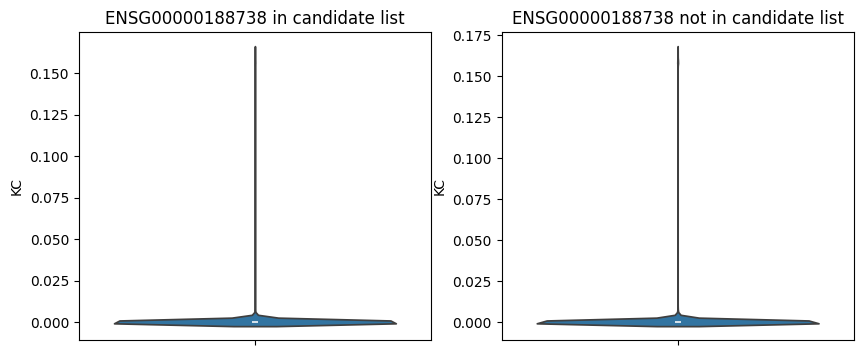

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(data=df, y='KC', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")

sns.violinplot(data=df_new, y='KC', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")

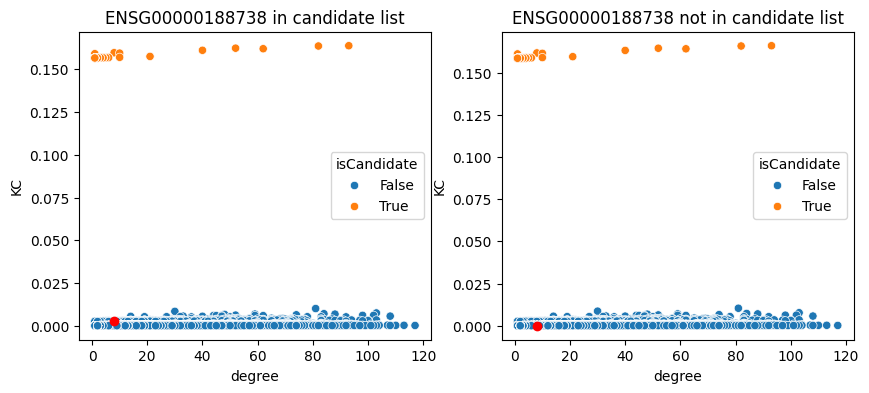

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df, x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')

sns.scatterplot(data=df_new, x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')

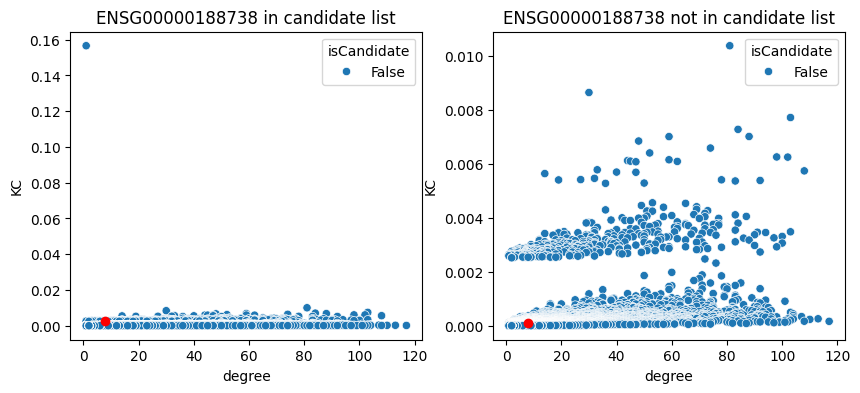

In [73]:
# plot only non candidates

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df[df['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')

sns.scatterplot(data=df_new[df_new['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')

(0.0, 0.005)

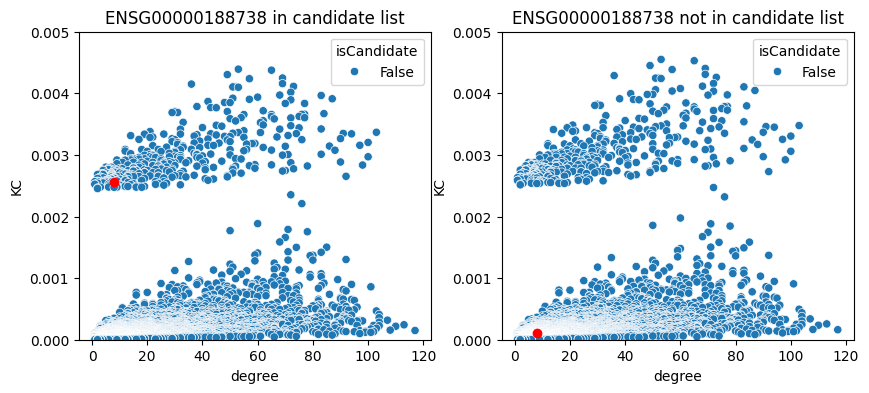

In [76]:
# plot only the lowest y limit

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df[df['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')
ax[0].set_ylim((0, 0.005))

sns.scatterplot(data=df_new[df_new['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')
ax[1].set_ylim((0, 0.005))